In [1]:
from typing import Callable
from functools import partial

import numpy as np
import pandas as pd
import scipy.odr as odr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import uncertainties

from adjustText import adjust_text

In [2]:
# Universal constants
hbar = 6.582119569e-16 # eV * s
c = 299792458 # m/s
m_e = 510.998e3 / c**2 # eV / c^2


def swap_ev_and_nm(v: float) -> float:
    # Convert an energy in eV to a wavelength in nm, and vice-versa
    return 1240 / v

In [3]:
def resonance(B: list[float], x: float) -> float:
    return B[0] * np.exp(-((x - B[1])**2) / (2 * B[2]**2)) + B[3]
resonance_model = odr.Model(resonance)

class FZSpectrum:
    def __init__(self, name: str, filename: str, x_range: tuple[float, float] | None = None):
        self.name = name

        # Load the spectrums
        df = pd.read_csv(filename, header=0)

        # Check if the series is in the file
        if f'I({name})' not in df.columns:
            raise ValueError(f'Series I({name}) not found in file {filename}. Available series: {", ".join([col for col in df.columns if col.startswith("I(")])}')

        # Calculate the absorbance
        df['Absorbance'] = -np.log10(df[f'I({name})'] / df['I(0)'])

        # Drop rows with NaN values
        df = df.dropna(subset=['Wavelength', 'Absorbance'])

        # We don't know the spectrometer that was used, so we'll assume some common uncertainties
        # The impact on the fits is minimal, so it's not critical if we're not more precise
        df['Wavelength unc'] = [0.1 for _ in df['Wavelength']]
        df['Absorbance unc'] = [0.003 for _ in df['Absorbance']]

        # Keep only the relevant columns
        self.df = df[['Wavelength', 'Wavelength unc', 'Absorbance', 'Absorbance unc']]

        self.fit_result: odr.Output | None = None
        self.x_range = x_range if x_range is not None else (self.df['Wavelength'].min(), self.df['Wavelength'].max())

    def fit(
            self, 
            x_range: tuple[float, float] | None = None, 
            initial_mu: float | None = None, 
            initial_sigma: float | None = None, 
            initial_a0: float | None = None,
            initial_y0: float | None = None,
            fix_y0: bool = False,
    ) -> odr.Output:
        if x_range is None: x_range = self.x_range

        x_data_mask = (self.df['Wavelength'] >= x_range[0]) & (self.df['Wavelength'] <= x_range[1])
        fit_data = odr.RealData(
            self.df['Wavelength'][x_data_mask], 
            self.df['Absorbance'][x_data_mask], 
            sx=self.df['Wavelength unc'][x_data_mask],
            sy=self.df['Absorbance unc'][x_data_mask],
        )


        if initial_mu is None:
            max_absorbance_index = self.df['Absorbance'].idxmax()
            initial_mu = self.df['Wavelength'].iloc[max_absorbance_index]
        if initial_sigma is None: initial_sigma = 50
        if initial_a0 is None: initial_a0 = self.df['Absorbance'].iloc[self.df['Wavelength'].searchsorted(initial_mu)]
        if initial_y0 is None: initial_y0 = 0
        initial_params = [initial_a0, initial_mu, initial_sigma, initial_y0]

        # List of 0/1 to indicate which parameters are fixed (0) or free (1), following ODRPACK's convention
        fix_params = [1, 1, 1, int(not fix_y0)]

        fit = odr.ODR(fit_data, resonance_model, beta0=initial_params, ifixb=fix_params)
        self.fit_result = fit.run()
        print(f'Fit stop: {self.fit_result.stopreason}')

        return self.fit_result

    @property
    def a0(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[0], self.fit_result.sd_beta[0])

    @property
    def mu(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[1], self.fit_result.sd_beta[1])

    @property
    def sigma(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[2], self.fit_result.sd_beta[2])

    @property
    def y_0(self) -> uncertainties.UFloat | None:
        if self.fit_result is None: return None
        return uncertainties.ufloat(self.fit_result.beta[3], self.fit_result.sd_beta[3])

    def get_fit_params_df(self) -> pd.DataFrame | None:
        if self.fit_result is None: return None
        df = pd.DataFrame({
            'mu': [self.mu],
            'sigma': [self.sigma],
            'A': [self.a0],
            'y_0': [self.y_0],
        })
        df.index = [self.name]
        return df

    def plot(self, mask: bool = False, x_range: tuple[float, float] | None = None, save: str | None = None):
        if mask or x_range:
            if not x_range: x_range = self.x_range
            mask = (self.df['Wavelength'] >= x_range[0]) & (self.df['Wavelength'] <= x_range[1])
        else:
            mask = [True for _ in self.df['Wavelength']]

        plt.errorbar(
            x=self.df['Wavelength'][mask], 
            y=self.df['Absorbance'][mask], 
            xerr=self.df['Wavelength unc'][mask], 
            yerr=self.df['Absorbance unc'][mask],
            label=self.name,
        )
        if self.fit_result is not None:
            x_fit = np.linspace(self.df['Wavelength'][mask].min(), self.df['Wavelength'][mask].max(), 100)
            plt.plot(x_fit, resonance(self.fit_result.beta, x_fit), color='red', label='Fit')

        plt.legend()

        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Absorbance [a.u.]')

        if save:
            plt.savefig(save)


def plot_all_spectrums(spectrums: list[FZSpectrum], plot_fits: bool = False, apply_show_masks: bool = False, shift_to_zero: bool = False, norm: bool = False, norm_to_max: bool = False, save: str | None = None):
    for i, spectrum in enumerate(spectrums):
        if apply_show_masks:
            mask = (spectrum.df['Wavelength'] >= spectrum.x_range[0]) & (spectrum.df['Wavelength'] <= spectrum.x_range[1])
        else:
            mask = np.array([True for _ in spectrum.df['Wavelength']])

        # Shift to zero
        shift = 0
        if shift_to_zero:
            shift = spectrum.df['Absorbance'][mask].min()

        scale = 1.0
        if norm:
            scale = 1/sum(spectrum.df['Absorbance'][mask] - shift)
        elif norm_to_max:
            scale = 1/(spectrum.df['Absorbance'][mask].max() - shift)

        plt.errorbar(
            x=spectrum.df['Wavelength'][mask], 
            y=(spectrum.df['Absorbance'][mask] - shift) * scale, 
            xerr=spectrum.df['Wavelength unc'][mask], 
            yerr=spectrum.df['Absorbance unc'][mask] * scale, 
            color=f'C{i}', 
            label=spectrum.name
        )
        if plot_fits and spectrum.fit_result is not None:
            x_fit = np.linspace(spectrum.df['Wavelength'][mask].min(), spectrum.df['Wavelength'][mask].max(), 100)
            plt.plot(x_fit, (resonance(spectrum.fit_result.beta, x_fit) - shift) * scale, color=f'C{i}', linestyle='dashed')

    plt.legend()

    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorbance [a.u.]')

    if save:
        plt.savefig(save)


def get_all_params(spectrums: list[FZSpectrum], mu_only: bool = False) -> pd.DataFrame:
    df_list = []
    for spectrum in spectrums:
        params_df = spectrum.get_fit_params_df()
        if params_df is not None: df_list.append(params_df)
    if df_list:
        df = pd.concat(df_list)

        if mu_only:
            return df[['mu']]
        else:
            return df
    else:
        return pd.DataFrame()

In [4]:
spectrums = {}

Fit stop: ['Sum of squares convergence']


/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mu,sigma,A,y_0
NaCl,460.76+/-0.21,36.82+/-0.29,1.096+/-0.006,0.480+/-0.004


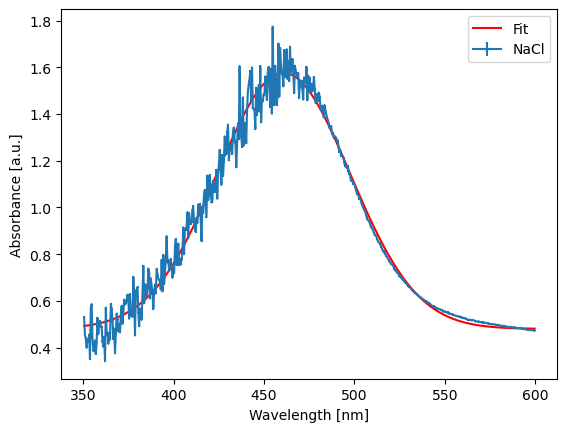

In [5]:
s = spectrums['NaCl'] = FZSpectrum('NaCl', 'data/data_series_1.csv', x_range=(350, 600))
s.fit(initial_mu=450)
s.plot(x_range=(350, 600))
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mu,sigma,A,y_0
KCl,503.81+/-0.08,12.96+/-0.31,0.247+/-0.005,0.404+/-0.006


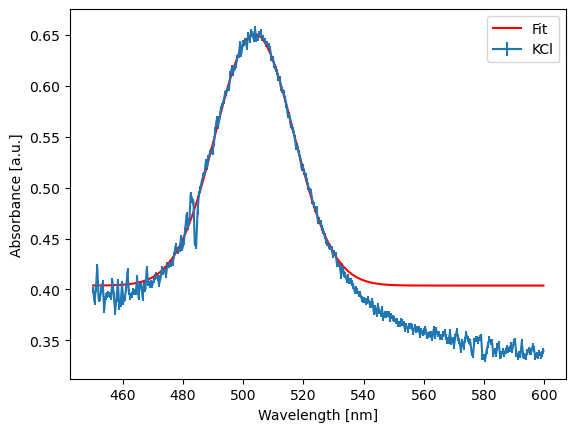

In [6]:
s = spectrums['KCl'] = FZSpectrum('KCl', 'data/data_series_1.csv', x_range=(480, 530))
s.fit(initial_mu=500)
s.plot(x_range=(450, 600))
s.get_fit_params_df()

Fit stop: ['Sum of squares convergence']


/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mu,sigma,A,y_0
KBr,618.87+/-0.11,47.27+/-0.22,0.2362+/-0.0008,0.5044+/-0.0008


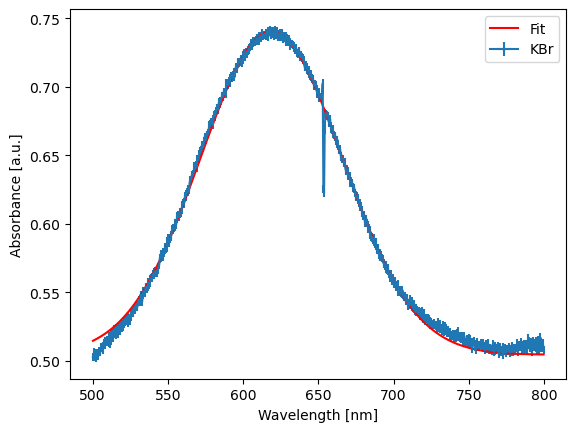

In [7]:
s = spectrums['KBr'] = FZSpectrum('KBr', 'data/data_series_2.csv', x_range=(500, 750))
s.fit(initial_mu=600)
s.plot(x_range=(500, 800))
s.get_fit_params_df()


Fit stop: ['Sum of squares convergence']


/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mu,sigma,A,y_0
KI,683.39+/-0.19,63.9+/-2.4,0.224+/-0.012,0.688+/-0.012


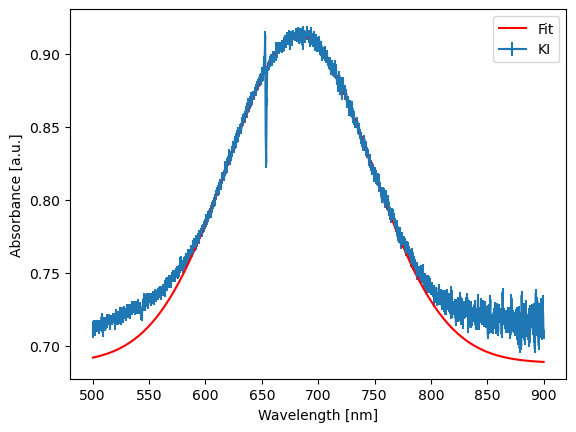

In [8]:
s = spectrums['KI'] = FZSpectrum('KI', 'data/data_series_2.csv', x_range=(600, 750))
s.fit(initial_mu=700)
s.plot(x_range=(500, 900))
s.get_fit_params_df()

,mu,sigma,A,y_0
NaCl,460.76+/-0.21,36.82+/-0.29,1.096+/-0.006,0.480+/-0.004
KCl,503.81+/-0.08,12.96+/-0.31,0.247+/-0.005,0.404+/-0.006
KBr,618.87+/-0.11,47.27+/-0.22,0.2362+/-0.0008,0.5044+/-0.0008
KI,683.39+/-0.19,63.9+/-2.4,0.224+/-0.012,0.688+/-0.012


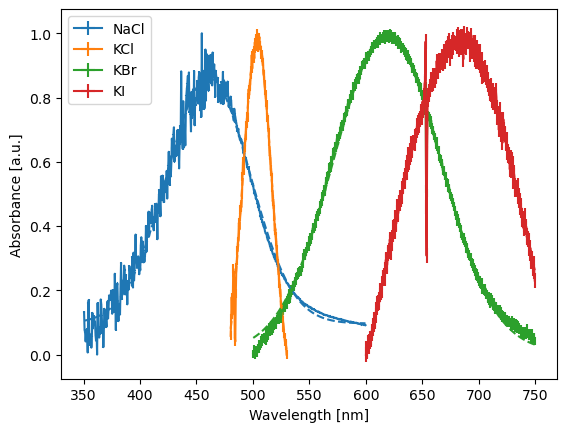

In [9]:
plot_all_spectrums(spectrums.values(), plot_fits=True, apply_show_masks=True, norm_to_max=True, shift_to_zero=True, save='output/all_spectrums.pdf')
get_all_params(spectrums.values(), mu_only=False)

In [10]:
# Load the literature references
all_crystals = pd.read_csv('data/references.csv', header=0, index_col=0)
all_crystals.columns = ['a [nm]', 'E Literature [eV]']
all_crystals['a unc. [nm]'] = 0.0001 # Fixed 0.0001 nm uncertainty for all lattice constants
all_crystals = all_crystals[['a [nm]', 'a unc. [nm]', 'E Literature [eV]']] # Reorder columns

# Initialize the measured energies (to maintain the "correct" order)
all_crystals['E Measured [eV]'] = float('nan')
all_crystals['E Measured unc. [eV]'] = float('nan')

# Initialize combined energies
all_crystals['E [eV]'] = all_crystals['E Literature [eV]']
all_crystals['E unc. [eV]'] = 0.001 * all_crystals['E [eV]']

# Add the measured spectrum peaks only to those rows corresponding to crystals that were measured
for name, spectrum in spectrums.items():
    all_crystals.loc[name, 'E Measured [eV]'] = swap_ev_and_nm(spectrum.mu).n
    all_crystals.loc[name, 'E Measured unc. [eV]'] = swap_ev_and_nm(spectrum.mu).s

    all_crystals.loc[name, 'E [eV]'] = all_crystals.loc[name, 'E Measured [eV]']
    all_crystals.loc[name, 'E unc. [eV]'] = all_crystals.loc[name, 'E Measured unc. [eV]']

all_crystals

,a [nm],a unc. [nm],E Literature [eV],E Measured [eV],E Measured unc. [eV],E [eV],E unc. [eV]
Sample,,,,,,,
LiF,0.4028,0.0001,5.083,NaN,NaN,5.083000,0.005083
LiCl,0.5140,0.0001,3.256,NaN,NaN,3.256000,0.003256
LiBr,0.5502,0.0001,2.767,NaN,NaN,2.767000,0.002767
LiI,0.6000,0.0001,3.176,NaN,NaN,3.176000,0.003176
NaF,0.4634,0.0001,3.702,NaN,NaN,3.702000,0.003702
NaCl,0.5640,0.0001,2.746,2.691220,0.001248,2.691220,0.001248
NaBr,0.5978,0.0001,2.345,NaN,NaN,2.345000,0.002345
NaI,0.6474,0.0001,2.063,NaN,NaN,2.063000,0.002063
KF,0.5348,0.0001,2.873,NaN,NaN,2.873000,0.002873


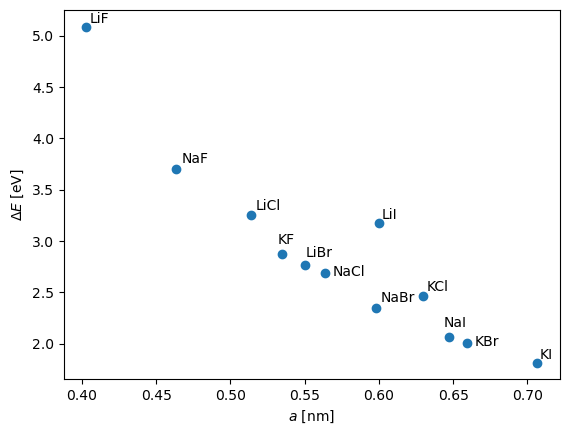

In [11]:
def plot_all(solutions: dict[str, Callable[[float], float] | dict[float, float]] | None = None, legend_outside: bool = False, y_range: tuple[float, float] | None = None, save: str | None = None):
    # Get x-axis range
    x_range = max(all_crystals['a [nm]']) - min(all_crystals['a [nm]'])

    labels = []
    for crystal in all_crystals.index:
        labels.append(plt.text(all_crystals.loc[crystal, 'a [nm]'], all_crystals.loc[crystal, 'E [eV]'], crystal, horizontalalignment='left'))

    # Plot the energies
    plt.errorbar(all_crystals['a [nm]'], all_crystals['E [eV]'], yerr=all_crystals['E unc. [eV]'], marker='o', linestyle='None')

    x_values = np.linspace(all_crystals['a [nm]'].min(), all_crystals['a [nm]'].max(), 1000)
    if solutions is not None:
        for name, sol in solutions.items():
            if isinstance(sol, dict):
                xs = list(sol.keys())
                ys = list(sol.values())

                if isinstance(ys[0], uncertainties.UFloat):
                    ys_err = [v.std_dev for v in ys]
                    ys = [v.n for v in ys]
                    plotline, _, _ = plt.errorbar(xs, ys, yerr=ys_err, marker='s', label=name, linestyle='None', zorder=100)
                    plotline.set_markerfacecolor('none')
                else:
                    plt.plot(xs, ys, marker='s', markerfacecolor='none', label=name, linestyle='None', zorder=100)
            else:
                plt.plot(x_values, sol(x_values), label=name, zorder=100)

    if solutions:
        if legend_outside:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            plt.legend()

    plt.xlabel(r'$a$ [nm]')
    plt.ylabel(r'$\Delta E$ [eV]')

    if y_range is not None:
        plt.ylim(y_range)

    adjust_text(labels, expand=(1.3, 1.3))

    if save:
        plt.savefig(save)

plot_all()

Fit stop: ['Sum of squares convergence']
Fit parameters: C = 0.9634628006851382 ± 0.0671199608710248, n = 1.8424001753958663 ± 0.1422989465880358


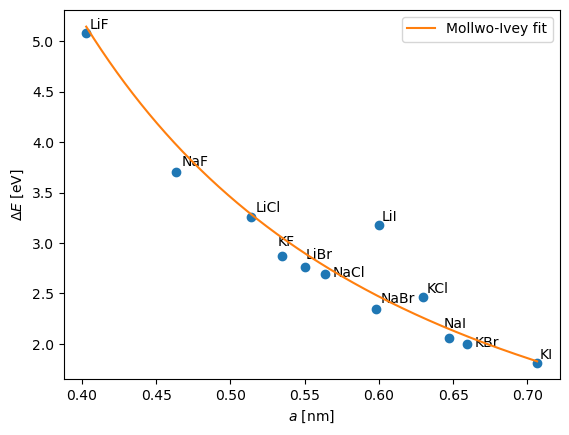

In [12]:
# Fit de Mollwo-Ivey relation
def mollwo_ivey(B: list[float], x: float) -> float:
    return B[0] * x**(-B[1])
mollwo_ivey_model = odr.Model(mollwo_ivey)

mask = all_crystals.index != 'LiI'
data = odr.RealData(
    all_crystals['a [nm]'][mask], 
    all_crystals['E [eV]'][mask], 
    sx=all_crystals['a unc. [nm]'][mask], 
    sy=all_crystals['E unc. [eV]'][mask],
)
fit = odr.ODR(data, mollwo_ivey_model, beta0=[1, 1])
fit_result = fit.run()
print(f'Fit stop: {fit_result.stopreason}')
print(f'Fit parameters: C = {fit_result.beta[0]} ± {fit_result.sd_beta[0]}, n = {fit_result.beta[1]} ± {fit_result.sd_beta[1]}')

mollvo_ivey_solution = partial(mollwo_ivey, fit_result.beta)
mi_solutions = {'Mollwo-Ivey fit': mollvo_ivey_solution}
plot_all(solutions=mi_solutions, save='output/mollwo_ivey_fit.pdf')

# Infinite Cubic and Spherical wells

We only consider the first transitions (from the fundamental level, to the first excited state)

## Infinite cubic well

$$E_{n_x, n_y, n_z} = \frac{\hbar^2 \pi^2}{2 m_e L^2} (n_x^2 + n_y^2 + n_z^2) \quad \implies \quad \Delta E(L) = E_{1, 0, 0} - E_{0, 0, 0} = E_{0, 1, 0} - E_{0, 0, 0} = E_{0, 0, 1} - E_{0, 0, 0} = \frac{3\hbar^2 \pi^2}{2 m_e L^2}.$$

## Infinite spherical well
$$E_{n, l} = \frac{\hbar^2}{2 m_e r^2} z_{n, l}^2 \quad \implies \quad \Delta E(r) = E_{1, 1} - E_{1, 0} = \frac{\hbar^2}{2 m_e r^2} (z_{1, 1}^2 - z_{1, 0}^2) = 10.315 \cdot \frac{\hbar^2}{2 m_e r^2},$$
where $z_{n, l}$ is the n-th zero of the j-th spherical Bessel function $j_l(r)$.

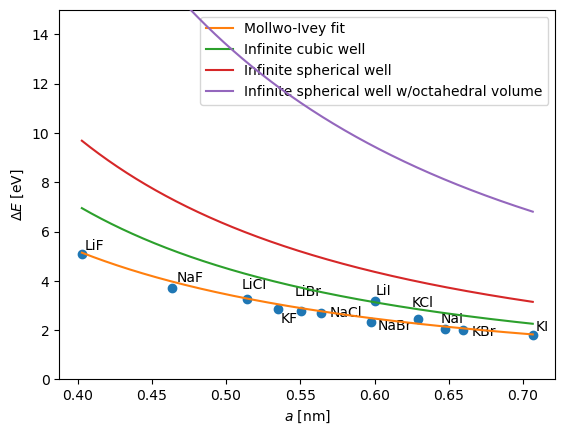

In [13]:
def infinite_cubic_well_transition(a: float) -> float:
    return 3 * hbar**2 * np.pi**2 / (2 * m_e * (a * 1e-9)**2)

def infinite_spherical_well_transition(r: float) -> float:
    return 10.315 * hbar**2 / (2 * m_e * (r * 1e-9)**2)

infinite_solutions = {
    'Infinite cubic well': infinite_cubic_well_transition,
    'Infinite spherical well': lambda a: infinite_spherical_well_transition(a/2),
    'Infinite spherical well w/octahedral volume': lambda a: infinite_spherical_well_transition(a * 0.34),
}
plot_all(solutions=mi_solutions | infinite_solutions, y_range=(0, 15), save='output/infinite_wells.pdf')

# Finite spherical well model

The solutions (and their derivatives) corresponding to bound eigenstates of the 3-dimensional finite spherical well must be continuous at the edge of the radial potential well ($r = a$), thus satisfying
$$A_l j_l(ka) = B_l h_l^1(i \kappa a), \quad A_l k j_l'(ka) = i B_l \kappa h_l^{1'}(i \kappa a),$$
where
$$E = -\frac{\hbar^2}{2m} \kappa^2, \quad \text{and} \quad E + V_0 = \frac{\hbar^2}{2m} k^2.$$
We can unify these last two expressions as
$$(ka)^2 + (\kappa a)^2 = \xi^2 + \eta^2 = \frac{2m V_0 a^2}{\hbar^2} = r_0^2,$$
with
$$\xi = ka, \quad \text{and} \quad \eta = \kappa a.$$

The boundary conditions can be rewritten together as
$$ka \frac{j_l'(ka)}{j_l(ka)} = i\kappa a \frac{h_l^1(i \kappa a)}{h_l^{1'}(i\kappa a)}.$$

We want to calculate the energies of the $l = 0$ and $l = 1$ states, involved in the fundamental-to-first-excited-state transition we want to model for the electron trapped in the lattice vacancy.

## Fundamental level ($l = 0$):
In this case,
$$j_0(x) = \frac{\sin x}{x}, \quad \text{and} \quad h_0^1(x) = j_0(x) + i y_0(x) = \frac{\sin x}{x} - i \frac{\cos x}{x}.$$
Put together, the solution takes the simplified form
$$\eta = -\frac{\xi}{\tan\xi},$$
where $\eta$ and $\xi$ are required to also be solutions to $\xi^2 + \eta^2 = r_0^2$


## First excited level ($l = 1$):
In this case,
$$j_1(x) = \frac{\sin x}{x^2} - \frac{\cos x}{x}, \quad \text{and} \quad h_1^1(x) = j_1(x) + i y_1(x) = \frac{\sin x}{x^2} - \frac{\cos x}{x} - i \frac{\cos x}{x^2} - i \frac{\sin x}{x}.$$
Applying the boundary conditions, we arrive at an implicit relation between $\eta$ and $\xi$, given by
$$\eta^2 \xi \cos\xi = \left( \xi^2 (1+\eta) + \eta^2 \right) \sin\xi.$$

In [14]:
def get_r0(v0, r):
    '''
    @param v0: in eV
    @param r: in nm
    '''
    return np.sqrt(2 * m_e * v0) * r*1e-9 / hbar

def fn_root(xi: float, r0: float) -> float:
    return np.sqrt(r0**2 - xi**2)

def negative_to_nan(v: float | np.ndarray) -> float | np.ndarray:
    '''
    Turn negative values to np.nan.
    
    Implementing it this way significantly speeds up the numeric methods
    vs vectorizing a single function.
    '''
    if isinstance(v, float):
        return np.nan if v < 0 else v
    elif isinstance(v, np.ndarray):
        arr = v.copy()
        arr[arr < 0] = np.nan
        return arr
    
    raise TypeError('Input must be a float or a numpy array')

def fn_sol_l0(xi: float) -> float:
    return negative_to_nan(-xi/np.tan(xi))

def fn_sol_l1_single(xi: float):
    def implicit_solution_l1(eta: float, xi: float):
        return eta**2 * xi * np.cos(xi) - (xi**2 * (1 + eta) + eta**2) * np.sin(xi)
    return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
fn_sol_l1 = np.vectorize(fn_sol_l1_single)

def get_fsw_energy(xi: float, r: float, v0: float) -> float:
    '''Invert the xi definition'''
    return hbar**2 * xi**2 / (2 * m_e * (r * 1e-9)**2) - v0

In [15]:
def find_all_roots(f, x_min: float, x_max: float, step: float | None = None, n_steps: int | None = None) -> list[float]:
    '''
    Use a sliding window approach to find all roots of the function f in the interval [x_min, x_max].
    '''
    if step and n_steps:
        raise ValueError('Cannot specify both step and n_steps')
    if not step:
        if not n_steps: n_steps = 1000
        step = (x_max - x_min)/n_steps
    xs = np.arange(x_min, x_max, step)

    roots = []
    for x1, x2 in zip(xs[:-1], xs[1:]):
        y1, y2 = f(x1), f(x2)
        
        # Check if function crosses zero in [x1, x2]
        if y1 == 0:
            # Exact zero at grid point
            roots.append(x1)
        elif y2 == 0:
            # Exact zero at grid point
            roots.append(x2)
        elif y1 * y2 < 0:
            # There is a root within the open interval
            try:
                # We'll find it with brentq
                roots.append(opt.brentq(f, x1, x2))
            except ValueError:
                # No root despite sign change (rare, numerical issue)
                pass

    # Round roots to overcome limits in the numerical precision,
    # and remove duplicates
    return np.unique(np.round(roots, 12))

/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


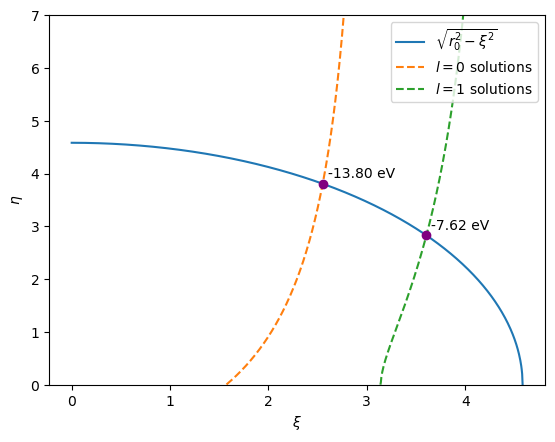

In [16]:
def get_fsw_transition_solutions(v0: float, r: float) -> tuple[list[float], list[float]]:
    '''
    Solve the finite spherical well equation numerically, and get the first and second bound states' xi values.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.

    @return: A tuple with the xi values for the fundamental (with l=0) and the first excited level (with l=1).
    '''
    r0 = get_r0(v0, r)

    # First, find the range in which we'll look for intersections between the curves.
    search_min = 1e-4 # Avoid the singularities at 0
    # The maximum number of bound states will be when r = r0, since we only want to cover the first levels.
    search_max = r0

    l0_zeros = find_all_roots(lambda xi: fn_sol_l0(xi) - fn_root(xi, r0), search_min, search_max)
    l1_zeros = find_all_roots(lambda xi: fn_sol_l1(xi) - fn_root(xi, r0), search_min, search_max)

    return l0_zeros, l1_zeros


def get_fsw_1st_transition_energy(v0: float, r: float) -> float:
    '''
    Solve the finite spherical well equation numerically, and get the energy of the
    fundamental (l=0) -> first excited level (l=1), if available.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.

    @return: The energy of the first transition (if allowed) or NaN.
    '''
    l0_zeros, l1_zeros = get_fsw_transition_solutions(v0, r)
    if len(l0_zeros) < 1 or len(l1_zeros) < 1:
        return np.nan

    return get_fsw_energy(l1_zeros[0], r, v0) - get_fsw_energy(l0_zeros[0], r, v0)


def plot_fsw_bound_states(v0: float = 20, r: float = 0.2, save: str | None = None):
    '''
    Solve the finite spherical well equation graphically, and get the first and second bound states' energy levels.

    @param v0: Depth of the well in eV.
    @param r: Radius of the well in nm.
    @param save: If specified, save the plot to this file.
    '''
    r0 = get_r0(v0, r)

    # X-axis values
    xi = np.linspace(1e-3, r0, 1000)

    # Clear the previous plot (in case we're using an interactive backend)
    plt.cla()

    # Draw the function
    plt.plot(xi, fn_root(xi, r0), label=r'$\sqrt{r_0^2 - \xi^2}$')
    plt.plot(xi, fn_sol_l0(xi), label=r'$l=0$ solutions', linestyle='--')
    plt.plot(xi, fn_sol_l1(xi), label=r'$l=1$ solutions', linestyle='--')

    #plt.axvline(r0, linestyle=':', color='gray')
    plt.xlabel(r'$\xi$')
    plt.ylabel(r'$\eta$')
    y_max = 7
    plt.ylim(0, y_max)

    plt.legend(loc='upper right')


    # Now solve the equation numerically
    l0_states, l1_states = get_fsw_transition_solutions(v0, r)

    labels = []
    def process_solutions(solutions: list[float], fn) -> tuple[list[float], list[float]]:
        x_lst = []
        y_lst = []
        for x in solutions:
            if x is np.nan: continue
            y = fn(x)
            if y > y_max: continue

            x_lst.append(x)
            y_lst.append(y)

            labels.append(plt.text(x, y, f'{get_fsw_energy(x, r, v0):.2f} eV', horizontalalignment='left'))

        return x_lst, y_lst

    plt.plot(*process_solutions(l0_states, fn_sol_l0), 'o', color='purple', linestyle='None')
    plt.plot(*process_solutions(l1_states, fn_sol_l1), 'o', color='purple', linestyle='None')

    adjust_text(labels, expand=(1.3, 1.3))

    if save:
        plt.savefig(save)

    plt.show()

plot_fsw_bound_states(v0=20, r=0.2, save='output/fsw_solutions_v20_r02.pdf')

In [ ]:
# Interactive plot with sliders :)

from ipywidgets import interactive
plot_model_interactive = lambda v0, r: plot_fsw_bound_states(v0, r, save=None)
interactive(plot_model_interactive, v0=(5, 30), r=(0.01, 0.5, 0.01))

interactive(children=(IntSlider(value=17, description='v0', max=30, min=5), FloatSlider(value=0.25, descriptio…

In [18]:
def get_v0_from_transition_energy(e: float, r: float) -> float:
    '''
    Get the finite spherical well potential V0 from the first transition energy
    
    @param e: Transition energy in eV
    @param r: Radius of the well in nm

    @return: The well depth V0 in eV
    '''
    
    # Minimize the difference between the experimental observation and the model prediction
    # to get the per-cyanine V0
    def fn(v0: float) -> float:
        model_e = get_fsw_1st_transition_energy(v0, r)
        # If there is no solution, return a large value, since minimize_scalar cannot handle NaNs
        if np.isnan(model_e):
            return np.inf
        return np.abs(model_e - e)

    res = opt.minimize_scalar(fn, bounds=(1, 20), method='bounded')
    print(res)

    return res.x


def get_v0_for_crystal(crystal: str) -> float:
    return get_v0_from_transition_energy(all_crystals.loc[crystal, 'E [eV]'], all_crystals.loc[crystal, 'a [nm]']/2)


def plot_deltae_for_crystal(crystal: str, v0_min: float = 4, v0_max: float = 15, v0_step: float = 0.1, save: str | None = None):
    '''
    Plot the energy difference between the measurement/literature and the fsw model prediction for a given crystal.

    @param crystal: The crystal to plot.
    @param v0_min: Minimum V0 value to plot.
    @param v0_max: Maximum V0 value to plot.
    @param v0_step: Step size for V0 values.
    @param save: If specified, save the plot to this file.
    '''
    if crystal not in all_crystals.index:
        raise ValueError(f'Crystal {crystal} not found in references.')

    r = all_crystals.loc[crystal, 'a [nm]'] / 2
    e_exp = all_crystals.loc[crystal, 'E [eV]']

    v0_values = np.arange(v0_min, v0_max, v0_step)
    deltae_values = [np.abs(get_fsw_1st_transition_energy(v0, r) - e_exp) for v0 in v0_values]

    plt.plot(v0_values, deltae_values)
    plt.xlabel(r'$V_0$ [eV]')
    plt.ylabel(r'$|E_{exp} - E_{FSW}$ [eV]|')
    plt.ylim(0, np.nanmax(deltae_values)*1.1)

    if save:
        plt.savefig(save)

/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


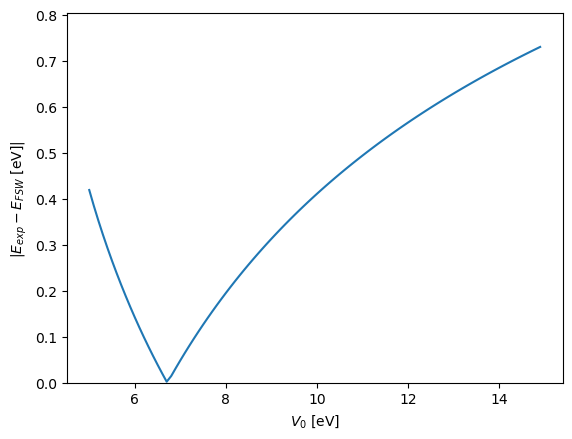

In [19]:
plot_deltae_for_crystal('NaCl', v0_min=5, v0_max=15, v0_step=0.1, save='output/deltae_nacl.pdf')

In [20]:
# Get the V0 values for all crystals
# Note: This takes a while to run (up to 30s per sample, ~3m in total), since it has to solve 
# the fsw equation numerically multiple times per crystal. Be patient...
for name in all_crystals.index:
    print(f'Fitting V0 for {name}')
    all_crystals.loc[name, 'V0 FSW [eV]'] = get_v0_for_crystal(name)

Fitting V0 for LiF


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/scipy/optimize/_optimize.py:2320: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/jeany/miniconda3/envs/cern/lib/python3.13/site-packages/scipy/optimize/_optimize.py:2321: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)


 message: Solution found.
 success: True
  status: 0
     fun: 2.5060783759300875e-07
       x: 12.162752982957768
     nit: 22
    nfev: 22
Fitting V0 for LiCl


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 3.867205617957836e-07
       x: 8.173628853312758
     nit: 22
    nfev: 22
Fitting V0 for LiBr


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.140212709278444e-07
       x: 6.730056556773998
     nit: 24
    nfev: 24
Fitting V0 for LiI
 message: Solution found.
 success: True
  status: 0
     fun: 6.658749995835933e-08
       x: 17.043246954728517
     nit: 22
    nfev: 22
Fitting V0 for NaF


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as meas

 message: Solution found.
 success: True
  status: 0
     fun: 4.151988974854248e-08
       x: 8.572080007007983
     nit: 22
    nfev: 22
Fitting V0 for NaCl
 message: Solution found.
 success: True
  status: 0
     fun: 1.4338654130696682e-07
       x: 6.71476782999543
     nit: 23
    nfev: 23
Fitting V0 for NaBr


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as meas

 message: Solution found.
 success: True
  status: 0
     fun: 2.6862043656095125e-07
       x: 5.706603277663353
     nit: 26
    nfev: 26
Fitting V0 for NaI
 message: Solution found.
 success: True
  status: 0
     fun: 2.3256851600095274e-07
       x: 5.213379712283875
     nit: 23
    nfev: 23
Fitting V0 for KF


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as meas

 message: Solution found.
 success: True
  status: 0
     fun: 1.3795790287929321e-07
       x: 6.849820761837704
     nit: 22
    nfev: 22
Fitting V0 for KCl
 message: Solution found.
 success: True
  status: 0
     fun: 1.0816741369268357e-07
       x: 7.708467811176889
     nit: 21
    nfev: 21
Fitting V0 for KBr


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as meas

 message: Solution found.
 success: True
  status: 0
     fun: 2.3194497877909726e-08
       x: 5.118902823045505
     nit: 23
    nfev: 23
Fitting V0 for KI


/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))
/var/folders/lz/n9c7_9yn68n0d3qz1llwp5pc0000gn/T/ipykernel_50700/3470556294.py:33: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return negative_to_nan(opt.fsolve(implicit_solution_l1, 4, args=(xi, )))


 message: Solution found.
 success: True
  status: 0
     fun: 2.1323249810301093e-07
       x: 4.91323173271989
     nit: 21
    nfev: 21


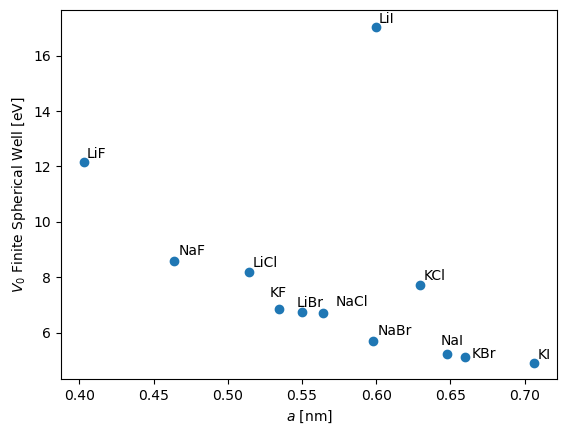

In [21]:
plt.plot(all_crystals['a [nm]'], all_crystals['V0 FSW [eV]'], marker='o', linestyle='None')
plt.xlabel(r'$a$ [nm]')
plt.ylabel(r'$V_0$ Finite Spherical Well [eV]')

labels = []
for crystal in all_crystals.index:
    labels.append(plt.text(all_crystals.loc[crystal, 'a [nm]'], all_crystals.loc[crystal, 'V0 FSW [eV]'], crystal, horizontalalignment='left'))
adjust_text(labels, expand=(1.3, 1.3))

plt.savefig('output/v0_fsw_vs_a.pdf')

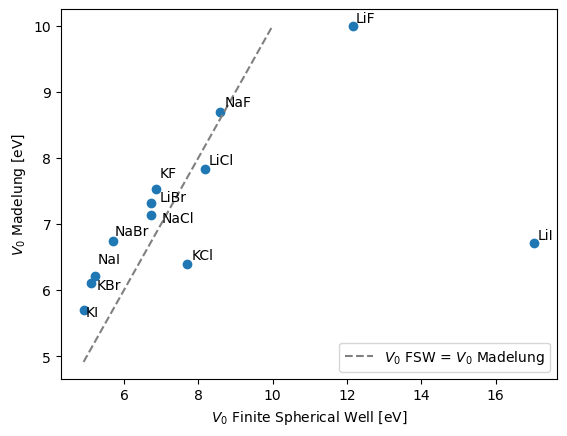

In [22]:
def get_v0_madelung(a: float) -> float:
    '''
    Estimate the well potential with the Madelung model.

    @param a: Lattice constant in nm
    @return: Estimated well potential in eV
    '''
    alpha_madelung_fcc = 1.74756
    q = 1 # Elementary ionic charge in e
    epsilon_0 = 55.26349406 * 1e-3 # e^2 / (eV * nm)
    r = a / 2 # Nearest neighbor distance
    rho = 0.1 * a # Repulsive range parameter

    return alpha_madelung_fcc * q**2 / (4 * np.pi * epsilon_0 * r) * (1 - rho / r)

all_crystals['V0 Madelung [eV]'] = get_v0_madelung(all_crystals['a [nm]'])
plt.plot(all_crystals['V0 FSW [eV]'], all_crystals['V0 Madelung [eV]'], marker='o', linestyle='None')
plt.xlabel('$V_0$ Finite Spherical Well [eV]')
plt.ylabel('$V_0$ Madelung [eV]')

x_values = np.linspace(all_crystals['V0 FSW [eV]'].min(), all_crystals['V0 Madelung [eV]'].max(), 2)
plt.plot(x_values, x_values, '--', color='gray', label='$V_0$ FSW = $V_0$ Madelung')

labels = []
for crystal in all_crystals.index:
    labels.append(plt.text(all_crystals.loc[crystal, 'V0 FSW [eV]'], all_crystals.loc[crystal, 'V0 Madelung [eV]'], crystal, horizontalalignment='left'))
adjust_text(labels, expand=(1.3, 1.3))

plt.legend()

plt.savefig('output/v0_fsw_vs_v0_madelung.pdf')